# Réalisez un traitement dans un environnement Big Data sur le Cloud

Installation des modules

In [32]:
!pip install tensorflow pillow numpy pandas pyspark pyarrow matplotlib

Import des librairies

In [33]:
# Mesure des durées d'exécution 
import time
# Pour lire les images qui auront été chargées au format binaire
import io
# Pour la gestion des chemins de fichiers
import os

# Désactivation des messages de debugging de tensorflow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Pour valider les résultats et les exporter en CSV
import pandas as pd
# Pour redimensionner les images
from PIL import Image
# Pour la manipulation d'arrays
import numpy as np

# Pour l'extraction de features des images
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import Model

# Création et manipulation de dataframes Spark
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, element_at, split
from pyspark.sql import SparkSession

# Pour conversion des features en vecteurs Spark
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf
# Pour réalisation de la PCA sur les features
from pyspark.ml.feature import PCA

print("Imports chargés ! ")


Imports chargés ! 


1. Définition des PATH pour charger les images et enregistrer les résultats

In [34]:
# Définition des chemins de base
PATH_ROOT = "/home/ayden/pyspark_project/data/"
PATH_Data = PATH_ROOT + "Tests/"
PATH_Results = PATH_ROOT + "Resultats/"

# Vérification des chemins
print(f"Chemin des images : {PATH_Data}")
print(f"Chemin des résultats : {PATH_Results}")

Chemin des images : /home/ayden/pyspark_project/data/Tests/
Chemin des résultats : /home/ayden/pyspark_project/data/Resultats/


In [35]:
from pyspark.sql import SparkSession

# Démarrer une session Spark
spark = (SparkSession
             .builder
             .appName('P8')  # Nom de l'application
             .master('local')  # Pour une exécution en local, local[x] si on veut utiliser x cœurs (sinon tous les dispos sont utilisés)
             .config("spark.sql.parquet.writeLegacyFormat", 'true')  # Pour pouvoir utiliser le format parquet lors de l'enregistrement des résultats
             .getOrCreate()  # obtenir une session spark existante ou si aucune n'existe, en créer une nouvelle
)

In [36]:
sc = spark.sparkContext

In [37]:
spark

3. Traitement des données

3.1 Chargement des données

In [38]:
# Chargement des images
images = spark.read.format("binaryFile") \
  .option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", "true") \
  .load(PATH_Data)

# Vérification du nombre total d'images
print(f"Nombre total d'images chargées : {images.count()}")

Nombre total d'images chargées : 300


In [39]:
images = images.withColumn('label', element_at(split(images['path'], '/'),-2))
print(images.printSchema())
print(images.select('path','label').show(5,False))

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- label: string (nullable = true)

None
+--------------------------------------------------------+-----+
|path                                                    |label|
+--------------------------------------------------------+-----+
|file:/home/ayden/pyspark_project/data/Tests/r_88_100.jpg|Tests|
|file:/home/ayden/pyspark_project/data/Tests/145_100.jpg |Tests|
|file:/home/ayden/pyspark_project/data/Tests/284_100.jpg |Tests|
|file:/home/ayden/pyspark_project/data/Tests/296_100.jpg |Tests|
|file:/home/ayden/pyspark_project/data/Tests/82_100.jpg  |Tests|
+--------------------------------------------------------+-----+
only showing top 5 rows

None


3.2 Préparation du modèle

Nous allons utiliser la technique du transfert learning pour extraire les features des images.

Nous allons utiliser le modèle MobileNetV2 pour sa rapidité d'exécution comparée à d'autres modèles comme VGG16 par exemple. Nous allons donc récupérer l'avant dernière couche du modèle en sortie. La dernière couche, avec sa fonction d'activation Softmax, est destinée à la classification, ce que nous ne souhaitons pas ici.

MobileNetV2, lorsqu'on l'utilise en incluant toutes ses couches, attend obligatoirement des images de dimension (224,224,3). Nos images étant toutes de dimension (100,100,3), nous devrons simplement les redimensionner avant de les confier au modèle.

Dans l'odre :

Nous chargeons le modèle MobileNetV2 avec les poids précalculés issus d'imagenet et en spécifiant le format de nos images en entrée
Nous créons un nouveau modèle avec :
en entrée : l'entrée du modèle MobileNetV2
en sortie : l'avant dernière couche du modèle MobileNetV2

In [40]:
model = MobileNetV2(weights='imagenet',
                    include_top=True,
                    input_shape=(224, 224, 3))

In [41]:
new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)

In [42]:
new_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

Tous les workeurs doivent pouvoir accéder au modèle ainsi qu'à ses poids.
Une bonne pratique consiste à charger le modèle sur le driver puis à diffuser
ensuite les poids aux différents workeurs.

In [43]:
brodcast_weights = sc.broadcast(new_model.get_weights())

Mettons cela sous forme de fonction :

In [44]:
def model_fn():
    """
    Returns a MobileNetV2 model with top layer removed 
    and broadcasted pretrained weights.
    """
    model = MobileNetV2(weights='imagenet',
                        include_top=True,
                        input_shape=(224, 224, 3))
    for layer in model.layers:
        layer.trainable = False
    new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)
    new_model.set_weights(brodcast_weights.value)  # Diffusion des poids
    return new_model

3.3 Définition du processus de chargement des images et application de leur featurisation à travers l'utilisation de pandas UDF

Ce notebook définit la logique par étapes, jusqu'à Pandas UDF.

L'empilement des appels est la suivante :

Pandas UDF
featuriser une série d'images pd.Series
prétraiter une image

In [45]:
def preprocess(content):
    """
    Preprocesses raw image bytes for prediction.
    """
    # Chargement des images au format binaire et redimensionnement
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)  # Conversion en array
    return preprocess_input(arr)

def featurize_series(model, content_series):
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    input = np.stack(content_series.map(preprocess))
    preds = model.predict(input)
    # Pour certaines couches, les caractéristiques de sortie seront des tenseurs multidimensionnels.
    # Nous aplatissions les tenseurs de caractéristiques en vecteurs pour faciliter le stockage dans les DataFrames Spark.
    output = [p.flatten() for p in preds]
    return pd.Series(output)

@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    '''
    This method is a Scalar Iterator pandas UDF wrapping our featurization function.
    The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).

    :param content_series_iter: This argument is an iterator over batches of data, where each batch
                              is a pandas Series of image data.
    '''
    # Avec PandasUDFType.SCALAR_ITER, nous pouvons charger le modèle une fois puis le réutiliser
    # pour plusieurs lots de données. Cela amortit les coûts liés au chargement des modèles volumineux.
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

/home/ayden/pyspark_project/pyspark_env/lib/python3.12/site-packages/pyspark/sql/pandas/functions.py:407: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


3.7.4 Exécution des actions d'extraction de features

Les Pandas UDF, sur de grands enregistrements (par exemple, de très grandes images),
peuvent rencontrer des erreurs de type Out Of Memory (OOM).
Si vous rencontrez de telles erreurs dans la cellule ci-dessous,
essayez de réduire la taille du lot Arrow via 'maxRecordsPerBatch'

Je n'utiliserai pas cette commande dans ce projet
et je laisse donc la commande en commentaire.

In [46]:
# spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "1024")

Nous pouvons maintenant exécuter la featurisation sur l'ensemble de notre DataFrame Spark.
REMARQUE : Cela peut prendre beaucoup de temps, tout dépend du volume de données à traiter.

Notre jeu de données de Test contient 22819 images.
Cependant, dans l'exécution en mode local,
nous traiterons un ensemble réduit de 300 images.

In [47]:
features_df = images.repartition(20).select(col("path"),
                                            col("label"),
                                            featurize_udf("content").alias("features")
                                           )

Rappel du PATH où seront inscrits les fichiers au format "parquet"
contenant nos résultats, à savoir, un DataFrame contenant 3 colonnes :

Path des images
Label de l'image
Vecteur de caractéristiques de l'image


In [48]:
print(PATH_Results)

/home/ayden/pyspark_project/data/Resultats/


Enregistrement des données traitées au format "parquet" :

In [49]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

features_df.write.mode("overwrite").parquet(PATH_Results)

E0000 00:00:1742328977.753207   18157 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742328977.759388   18157 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742328977.789501   18157 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742328977.789545   18157 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742328977.789547   18157 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742328977.789548   18157 computation_placer.cc:177] computation placer already registered. Please check linka

In [50]:
features_df.printSchema()

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = true)



PCA

In [73]:
def nb_composante(dataframe, nb_comp=220):
    '''
    Recherche du nombre de composantes expliquant 95% de la variance
    :param dataframe: Le dataframe d'images
    :param nb_comp: Le nombre de composantes initiales pour l'ACP
    :return: Le nombre de composantes expliquant 95% de la variance totale
    '''

    # Initialisation de l'analyse en composantes principales (ACP)
    pca = PCA(k=nb_comp, inputCol="features_scaled", outputCol="features_pca")

    # Entraînement du modèle PCA
    model_pca = pca.fit(dataframe)

    # Calcul de la variance expliquée
    varexpl = model_pca.explainedVariance * 100

    # Visualisation de la variance expliquée
    plt.figure(figsize=(11, 7))
    plt.bar(np.arange(len(varexpl)) + 1, varexpl)

    # Calcul de la variance cumulée
    cumSumVar = varexpl.cumsum()
    plt.plot(np.arange(len(varexpl)) + 1, cumSumVar, c="red", marker='o')

    # Ligne de référence à 95% de variance expliquée
    plt.axhline(y=95, linestyle="--", color="green", linewidth=1)

    # Recherche du nombre de composantes pour atteindre 95% de variance expliquée
    limit = 95
    min_plans = np.argmax(cumSumVar >= limit) + 1
    plt.axvline(x=min_plans, linestyle="--", color="green", linewidth=1)

    # Configuration de l'axe des x et y
    plt.xlabel("Nombre de composantes principales")
    plt.ylabel("Pourcentage de variance expliquée")
    plt.title("{:.0f}% de la variance totale est expliquée par les {} premiers axes".format(limit, min_plans))
    plt.xticks(np.arange(0, nb_comp + 1, 10))
    plt.xlim(left=0)

    # Affichage du graphique
    plt.show()

    # Retour du nombre de composantes nécessaires pour expliquer 95% de la variance
    return min_plans

In [54]:
def preprocess_pca(dataframe):
  '''
     Préparation des données :
     - transformation en vecteur dense
     - standardisation
     param : dataframe : dataframe d'images
     return : dataframe avec features vecteur dense standardisé
  '''

  # Préparation des données - conversion des données images en vecteur dense
  transform_vecteur_dense = udf(lambda r: Vectors.dense(r), VectorUDT())
  dataframe = dataframe.withColumn('features_vectors', transform_vecteur_dense('features'))

  # Standardisation obligatoire pour PCA
  scaler_std = StandardScaler(inputCol="features_vectors", outputCol="features_scaled", withStd=True, withMean=True)
  model_std = scaler_std.fit(dataframe)
  # Mise à l'échelle
  dataframe = model_std.transform(dataframe)

  return dataframe

In [55]:
from pyspark.ml.feature import PCA
from pyspark.sql.functions import udf
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.feature import StandardScaler

In [62]:
# Pré-processing (vecteur dense, standardisation)
df_pca = preprocess_pca(features_df)

E0000 00:00:1742335787.742682   30690 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742335787.745704   30690 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742335787.754341   30690 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742335787.754365   30690 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742335787.754367   30690 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742335787.754367   30690 computation_placer.cc:177] computation placer already registered. Please check linka

E0000 00:00:1742339240.927638   45467 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742339240.930296   45467 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742339240.937011   45467 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742339240.937035   45467 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742339240.937037   45467 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742339240.937038   45467 computation_placer.cc:177] computation placer already registered. Please check linka

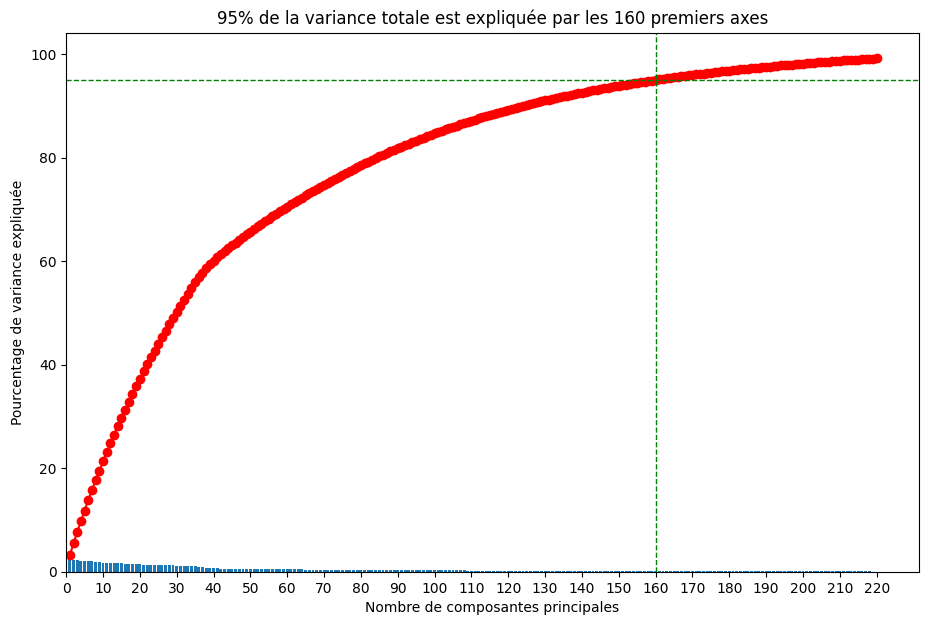

np.int64(160)

In [74]:
# Nombre de composante expliquant 95% de la variance
n_components = nb_composante(df_pca)
n_components

On effectue plusieurs tests :
pour 94 % on a besoin de 151 composantes.
pour 95 % on a besoin de 160 composantes.
pour 96 % on a besoin de 170 composantes.
pour 97 % on a besoin de 183 composantes.
pour 98 % on a besoin de 197 composantes.
pour 99% on a besoin de 216 composantes.

160 est un excellent compromis :
Bonne réduction de dimension
Perte d'information minimale
Optimisation du temps de calcul

In [75]:
# Entrainement de l'algorithme
pca = PCA(k=n_components, inputCol='features_scaled', outputCol='features_pca')
model_pca = pca.fit(df_pca)

# Transformation des images sur les k premières composantes
df_reduit = model_pca.transform(df_pca)

E0000 00:00:1742339964.006025   48567 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742339964.008674   48567 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742339964.015445   48567 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742339964.015467   48567 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742339964.015468   48567 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742339964.015469   48567 computation_placer.cc:177] computation placer already registered. Please check linka

In [77]:
# Write the result after PCA to a parquet file
df_reduit.write.mode("overwrite").parquet(PATH_Results + "/pca_results")

25/03/19 00:21:24 WARN DAGScheduler: Broadcasting large task binary with size 1895.3 KiB
E0000 00:00:1742340084.722963   51300 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742340084.725486   51300 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742340084.731734   51300 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742340084.731758   51300 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742340084.731760   51300 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1742340084.731761   5

In [79]:
print(PATH_Results + "/pca_results")

/home/ayden/pyspark_project/data/Resultats//pca_results


3.8 Chargement des données enregistrées et validation du résultat
On charge les données fraichement enregistrées dans un DataFrame Pandas :

In [80]:
df = pd.read_parquet(PATH_Results, engine='pyarrow')

In [81]:
df_pca=spark.read.parquet(PATH_Results + "/pca_results", engine='pyarrow')

In [82]:
print(df_pca.printSchema())

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- features_vectors: vector (nullable = true)
 |-- features_scaled: vector (nullable = true)
 |-- features_pca: vector (nullable = true)

None


In [83]:
df.head()

,path,label,features
0,file:/home/ayden/pyspark_project/data/Tests/22...,Tests,"[0.0, 0.900545, 2.2457604, 0.0, 0.028803367, 0..."
1,file:/home/ayden/pyspark_project/data/Tests/r_...,Tests,"[0.18596514, 3.726521, 0.21875712, 0.0, 0.3515..."
2,file:/home/ayden/pyspark_project/data/Tests/74...,Tests,"[0.11136709, 0.010855801, 0.0, 0.0, 1.2359263,..."
3,file:/home/ayden/pyspark_project/data/Tests/r_...,Tests,"[0.0, 0.58772, 0.049004924, 0.15960301, 2.2575..."
4,file:/home/ayden/pyspark_project/data/Tests/r_...,Tests,"[2.2115886, 0.0, 0.029405992, 0.28084335, 0.23..."


In [84]:
df_pca

DataFrame[path: string, label: string, features: array<float>, features_vectors: vector, features_scaled: vector, features_pca: vector]

On valide que la dimension du vecteur de caractéristiques des images est bien de dimension 1280 :

In [85]:
df.loc[0,'features'].shape

(1280,)

In [86]:
# Sélectionner la colonne "pca_features" et la renommer en "features"
df_pca_features = df_pca.select(col("features_pca").alias("features"))

# Récupérer la première ligne du DataFrame
first_row = df_pca_features.first()

# Obtenir la dimension de la colonne "features"
dimension = len(first_row["features"])
print("Dimension après réduction PCA:", dimension)

Dimension après réduction PCA: 160


In [87]:
df_pca.columns

['path',
 'label',
 'features',
 'features_vectors',
 'features_scaled',
 'features_pca']

In [88]:
df_pca.count()

300

Bilan : Nous venons de valider le processus sur un jeu de données allégé en local
où nous avons simulé un cluster de machines en répartissant la charge de travail
sur différents cœurs de processeur au sein d'une même machine. Sur ce test en local, nous avons mis en place la réduction de dimension avec PCA

Nous allons maintenant généraliser le processus en déployant notre solution
sur un réel cluster de machines dans le notebook deploiement cloud et nous travaillerons désormais sur la totalité
des 22819 images de notre dossier "Test".